In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-pendulum'
sys.path.append(EXPERIMENT_DIR)

from data import get_DLNN_dataset, get_lagrangian_trajectory, lagrangian_dynamics_fn, lagrangian_fn ,reighley_dissipation_fn
from nn_models import MLP
from dlnn import DLNN

In [2]:
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.family'] = 'Arial'

In [3]:
args = {"input_dim":2,"hidden_dim":512,"output_dim":2,"nonlinearity":"swish"}

In [4]:
def get_model(label):
    if label =='dlnn' :
        nn_model = MLP(args["input_dim"], args["hidden_dim"], 2, args["nonlinearity"])
        model = DLNN(model=nn_model)
        model_name = 'dlnn'
        path = '{}/pend-{}.pt'.format(EXPERIMENT_DIR,model_name)
    else :
        model = MLP(args["input_dim"], args["hidden_dim"], args["output_dim"], args["nonlinearity"])
        model_name = 'baseline'
        path = '{}/pend-{}.pt'.format(EXPERIMENT_DIR,model_name)
    model.load_state_dict(torch.load(path))
    return model

In [5]:
def integrate_model(model, t_span, y0,**kwargs):
    def fun(t, np_x):
        np_x[0] = np.mod(np_x[0],2*np.pi)
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0 ,**kwargs)

In [6]:
def bc_integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        np_x[0] = np.mod(np_x[0],2*np.pi)
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [7]:
dlnn_model = get_model("dlnn")

In [8]:
bc_model = get_model("baseline")

In [9]:
t_span = [0,15]
y0 = np.asarray([np.pi,-2])
t_eval = np.linspace(t_span[0], t_span[1], 450)
dkwargs = {'t_eval': t_eval, 'rtol': 1e-4}
kwargs = {'t_eval': t_eval, 'rtol': 1e-4}


In [10]:
%time dlnn_ivp = integrate_model(dlnn_model, t_span, y0, **dkwargs)

CPU times: user 25.1 s, sys: 139 ms, total: 25.3 s
Wall time: 5.12 s


In [11]:
%time true_ivp = solve_ivp(fun=lagrangian_dynamics_fn, t_span=t_span, y0=y0,**kwargs)

CPU times: user 1.45 s, sys: 874 µs, total: 1.45 s
Wall time: 1.45 s


In [12]:
%time bc_ivp = bc_integrate_model(bc_model, t_span, y0, **kwargs)

CPU times: user 1.86 s, sys: 28.6 ms, total: 1.89 s
Wall time: 341 ms


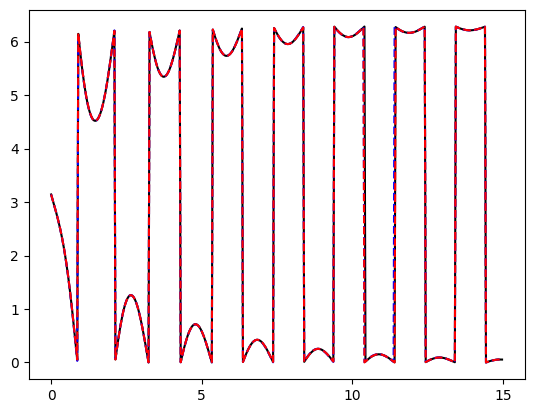

In [13]:
plt.xticks(np.arange(0,15*30+1,15*30/3),np.arange(0,15+1,5))
plt.plot(np.mod(true_ivp['y'][0],2*np.pi),'k')
plt.plot(np.mod(dlnn_ivp['y'][0],2*np.pi),'b--')
plt.plot(np.mod(bc_ivp['y'][0],2*np.pi),'r--')
plt.show()

In [14]:
t_span = [0,5]
y0 = np.asarray([np.pi,-10])
t_eval = np.linspace(t_span[0], t_span[1], 150)
dkwargs = {'t_eval': t_eval, 'rtol': 1e-4}
kwargs = {'t_eval': t_eval, 'rtol': 1e-4}

In [15]:
true_ivp = solve_ivp(fun=lagrangian_dynamics_fn, t_span=t_span, y0=y0,**kwargs)
dlnn_ivp = integrate_model(dlnn_model,t_span, y0,**kwargs)
bc_ivp = bc_integrate_model(bc_model, t_span, y0,**kwargs)

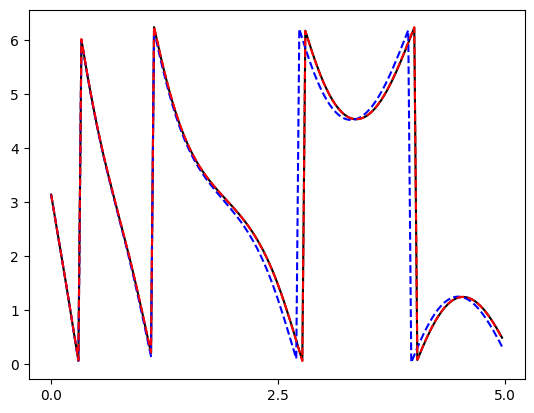

In [16]:
plt.xticks(np.arange(0,5*30+1,5*30/2),np.arange(0,5+1,2.5))
plt.plot(np.mod(true_ivp['y'][0],2*np.pi),'k')
plt.plot(np.mod(dlnn_ivp['y'][0],2*np.pi),'b--')
plt.plot(np.mod(bc_ivp['y'][0],2*np.pi),'r--')
plt.show()

In [17]:
RHO = 2.0
GRIDSIZE = 25

In [18]:
LINE_SEGMENTS = 10
LINE_WIDTH = 40
ARROW_SCALE = 100
ARROW_WIDTH = 8e-3
qkwargs = {'width': ARROW_WIDTH, 'scale': ARROW_SCALE} # quiver kwargs

In [19]:
qs = np.arange(-np.pi ,np.pi+0.001,2*np.pi/10)
qdots = np.arange(-10,11,20/10)
DPpoints = np.empty([1,2,2])
BPpoints = np.empty([1,2,2])
Apoints = np.empty([1,2,2])

for q in qs:
    for qdot in qdots:
        y0 = np.hstack([np.mod(q,2*np.pi),qdot])
        Adx = lagrangian_dynamics_fn(None,y0)
        tx = torch.tensor(y0, requires_grad=True, dtype=torch.float32).view(1,2)
        DPdx = dlnn_model.time_derivative(tx).detach().numpy().reshape(2)
        BPdx = bc_model(tx).detach().numpy().reshape(2)
        Apoint = np.hstack([q,qdot,Adx])
        Apoints = np.vstack([Apoints,Apoint.reshape(1,2,2)])
        DPpoint = np.hstack([q,qdot,DPdx])
        DPpoints = np.vstack([DPpoints,DPpoint.reshape(1,2,2)])
        BPpoint = np.hstack([q,qdot,BPdx])
        BPpoints = np.vstack([BPpoints,BPpoint.reshape(1,2,2)])
DPpoints = DPpoints[1:]
BPpoints = BPpoints[1:]
Apoints = Apoints[1:]

In [20]:
LINE_SEGMENTS = 10
LINE_WIDTH = 40
ARROW_SCALE = 100
ARROW_WIDTH = 8e-3
qkwargs = {'width': ARROW_WIDTH, 'scale': ARROW_SCALE} # quiver kwargs

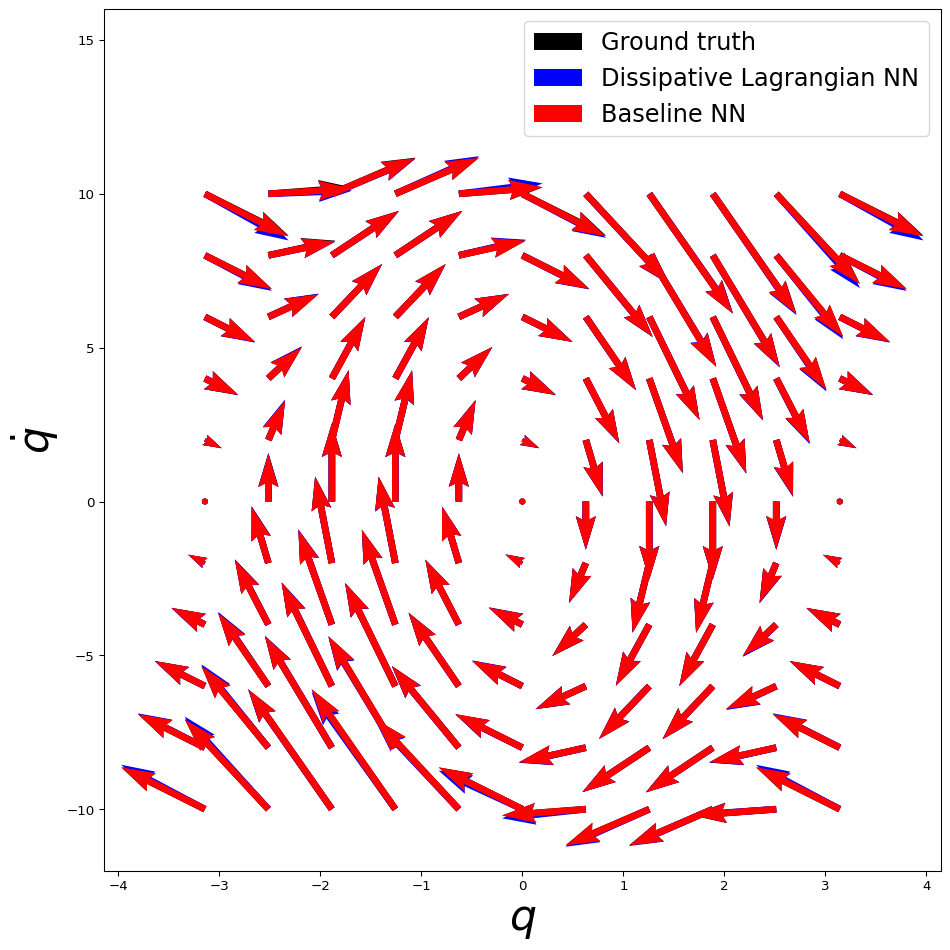

In [21]:
# fig = plt.figure(figsize=[9,6], dpi=500)
# fig = plt.figure(figsize=[6,6], dpi=500)
fig = plt.figure(figsize=[10,10], dpi=96)

# plt.title('Graph')
plt.xlabel(r'$q$', fontsize=32)
plt.ylabel(r'$\dot{q}$', fontsize=32)
plt.xlim(-np.pi-1,np.pi+1)
plt.ylim(-12,16)
plt.quiver(Apoints[:,0,0],Apoints[:,0,1], Apoints[:,1,0],Apoints[:,1,1], color='k',label="Ground truth",**qkwargs)
plt.quiver(DPpoints[:,0,0],DPpoints[:,0,1], DPpoints[:,1,0],DPpoints[:,1,1], color='b',label="Dissipative Lagrangian NN",**qkwargs)
plt.quiver(BPpoints[:,0,0],BPpoints[:,0,1], BPpoints[:,1,0],BPpoints[:,1,1], color='r',label="Baseline NN",**qkwargs)

plt.legend(loc='upper right', fontsize=18)
plt.tight_layout()

plt.show()


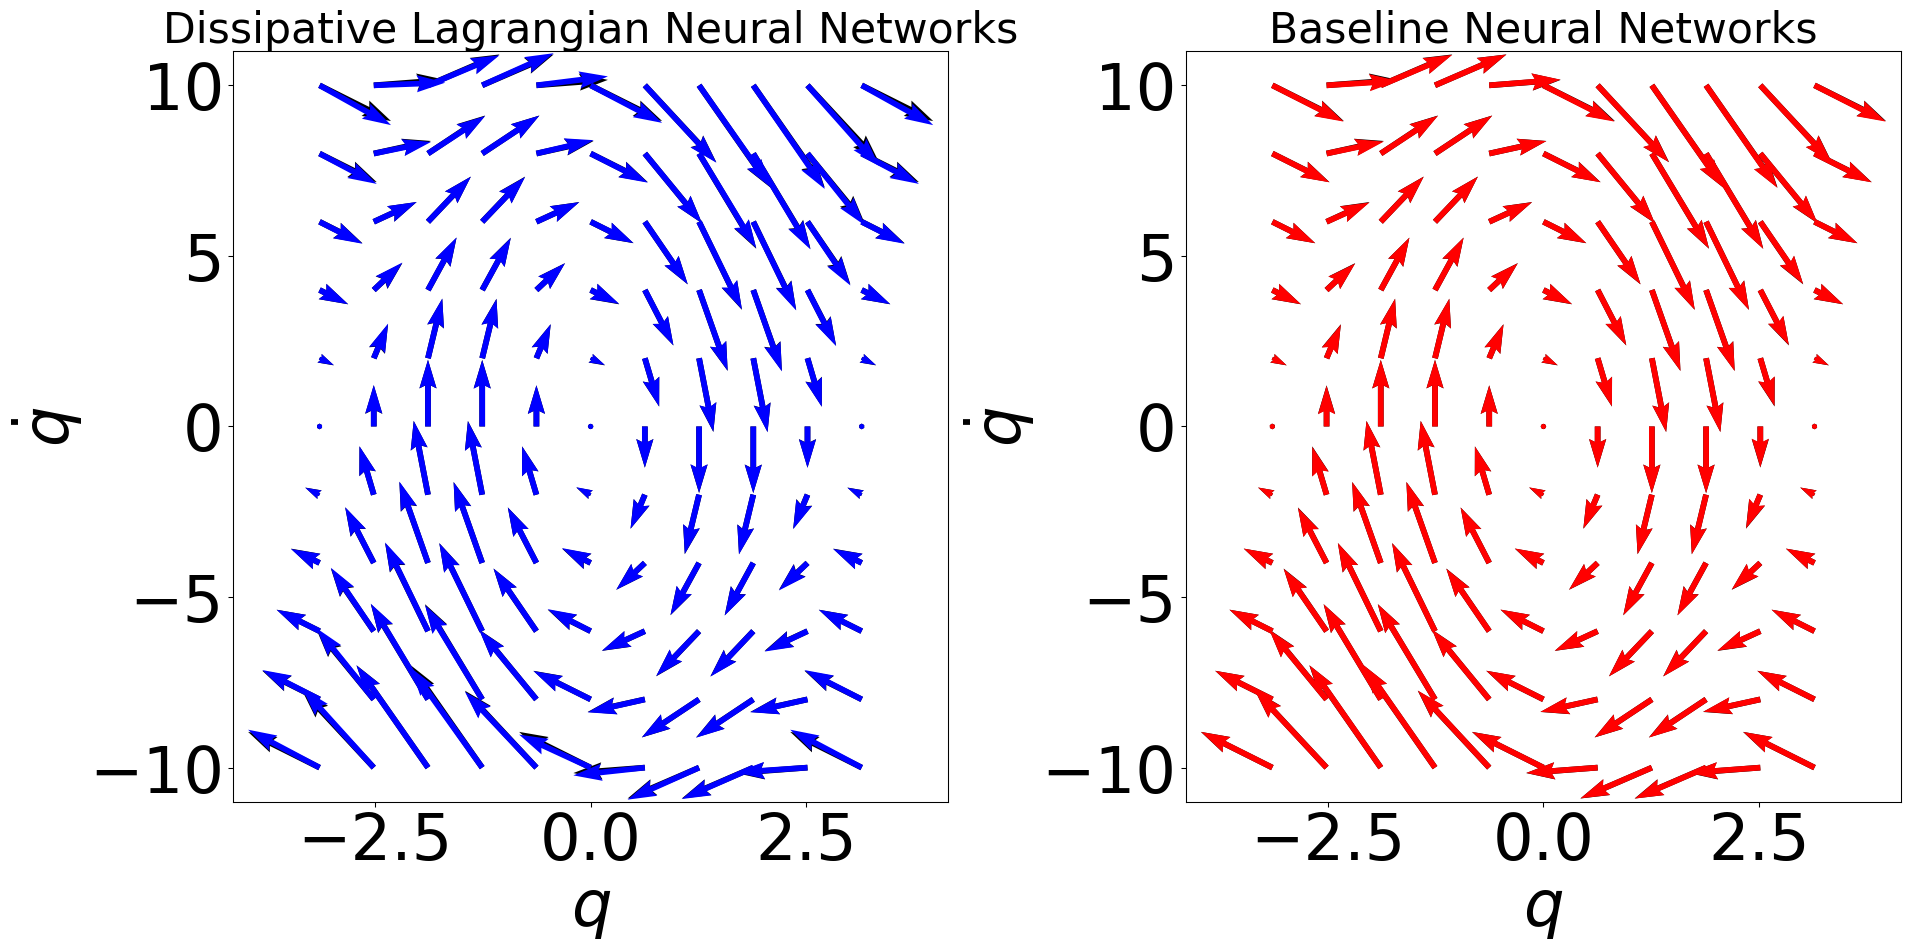

In [22]:
fig = plt.figure(figsize=[20,10], dpi=96)

plt.subplot(121)
plt.title('Dissipative Lagrangian Neural Networks',fontsize = 32)
plt.tick_params(labelsize=48)
plt.xlabel(r'$q$', fontsize=48)
plt.ylabel(r'$\dot{q}$', fontsize=48)
plt.xlim(-np.pi-1,np.pi+1)
# plt.ylim(-11,14)
plt.ylim(-11,11)
plt.quiver(Apoints[:,0,0],Apoints[:,0,1], Apoints[:,1,0],Apoints[:,1,1], color='k',label="Ground truth",**qkwargs)
plt.quiver(DPpoints[:,0,0],DPpoints[:,0,1], DPpoints[:,1,0],DPpoints[:,1,1], color='b',label="Dissipative Lagrangian NN",**qkwargs)

plt.subplot(122)
plt.title('Baseline Neural Networks',fontsize = 32)
plt.tick_params(labelsize=48)
plt.xlabel(r'$q$', fontsize=48)
plt.ylabel(r'$\dot{q}$', fontsize=48)
plt.xlim(-np.pi-1,np.pi+1)
# plt.ylim(-11,14)
plt.ylim(-11,11)
plt.quiver(Apoints[:,0,0],Apoints[:,0,1], Apoints[:,1,0],Apoints[:,1,1], color='k',label="Ground truth",**qkwargs)
plt.quiver(Apoints[:,0,0],Apoints[:,0,1], BPpoints[:,1,0],BPpoints[:,1,1], color='r',label="Dissipative Lagrangian NN",**qkwargs)

plt.tight_layout()

plt.show()

In [23]:
BMSE=((BPpoints[:,1,0]-Apoints[:,1,0])**2+(BPpoints[:,1,1]-Apoints[:,1,1])**2).mean()
DMSE=((DPpoints[:,1,0]-Apoints[:,1,0])**2+(DPpoints[:,1,1]-Apoints[:,1,1])**2).mean()


In [24]:
print(BMSE)
print(DMSE)

0.001144771235177502
0.022187452967161594


In [25]:
t_span = [0,15]
y0 = np.asarray([np.pi-1,1])
t_eval = np.linspace(t_span[0], t_span[1], 15*30)
kwargs = {'t_eval': t_eval, 'rtol': 1e-4}

In [26]:
true_ivp = solve_ivp(fun=lagrangian_dynamics_fn, t_span=t_span, y0=y0,**kwargs)
dlnn_ivp = integrate_model(dlnn_model,t_span, y0,**kwargs)
bc_ivp = bc_integrate_model(bc_model, t_span, y0,**kwargs)

In [27]:
bplot = np.empty(1)
for i in bc_ivp['y'][0] :
    if i >= np.pi :
        i -= 2*np.pi
    bplot = np.hstack([bplot,i])

bplot = bplot[1:]

In [28]:
dlplot = np.empty(1)
for i in dlnn_ivp['y'][0] :
    if i >= np.pi :
        i -= 2*np.pi
    dlplot = np.hstack([dlplot,i])

dlplot =dlplot[1:]

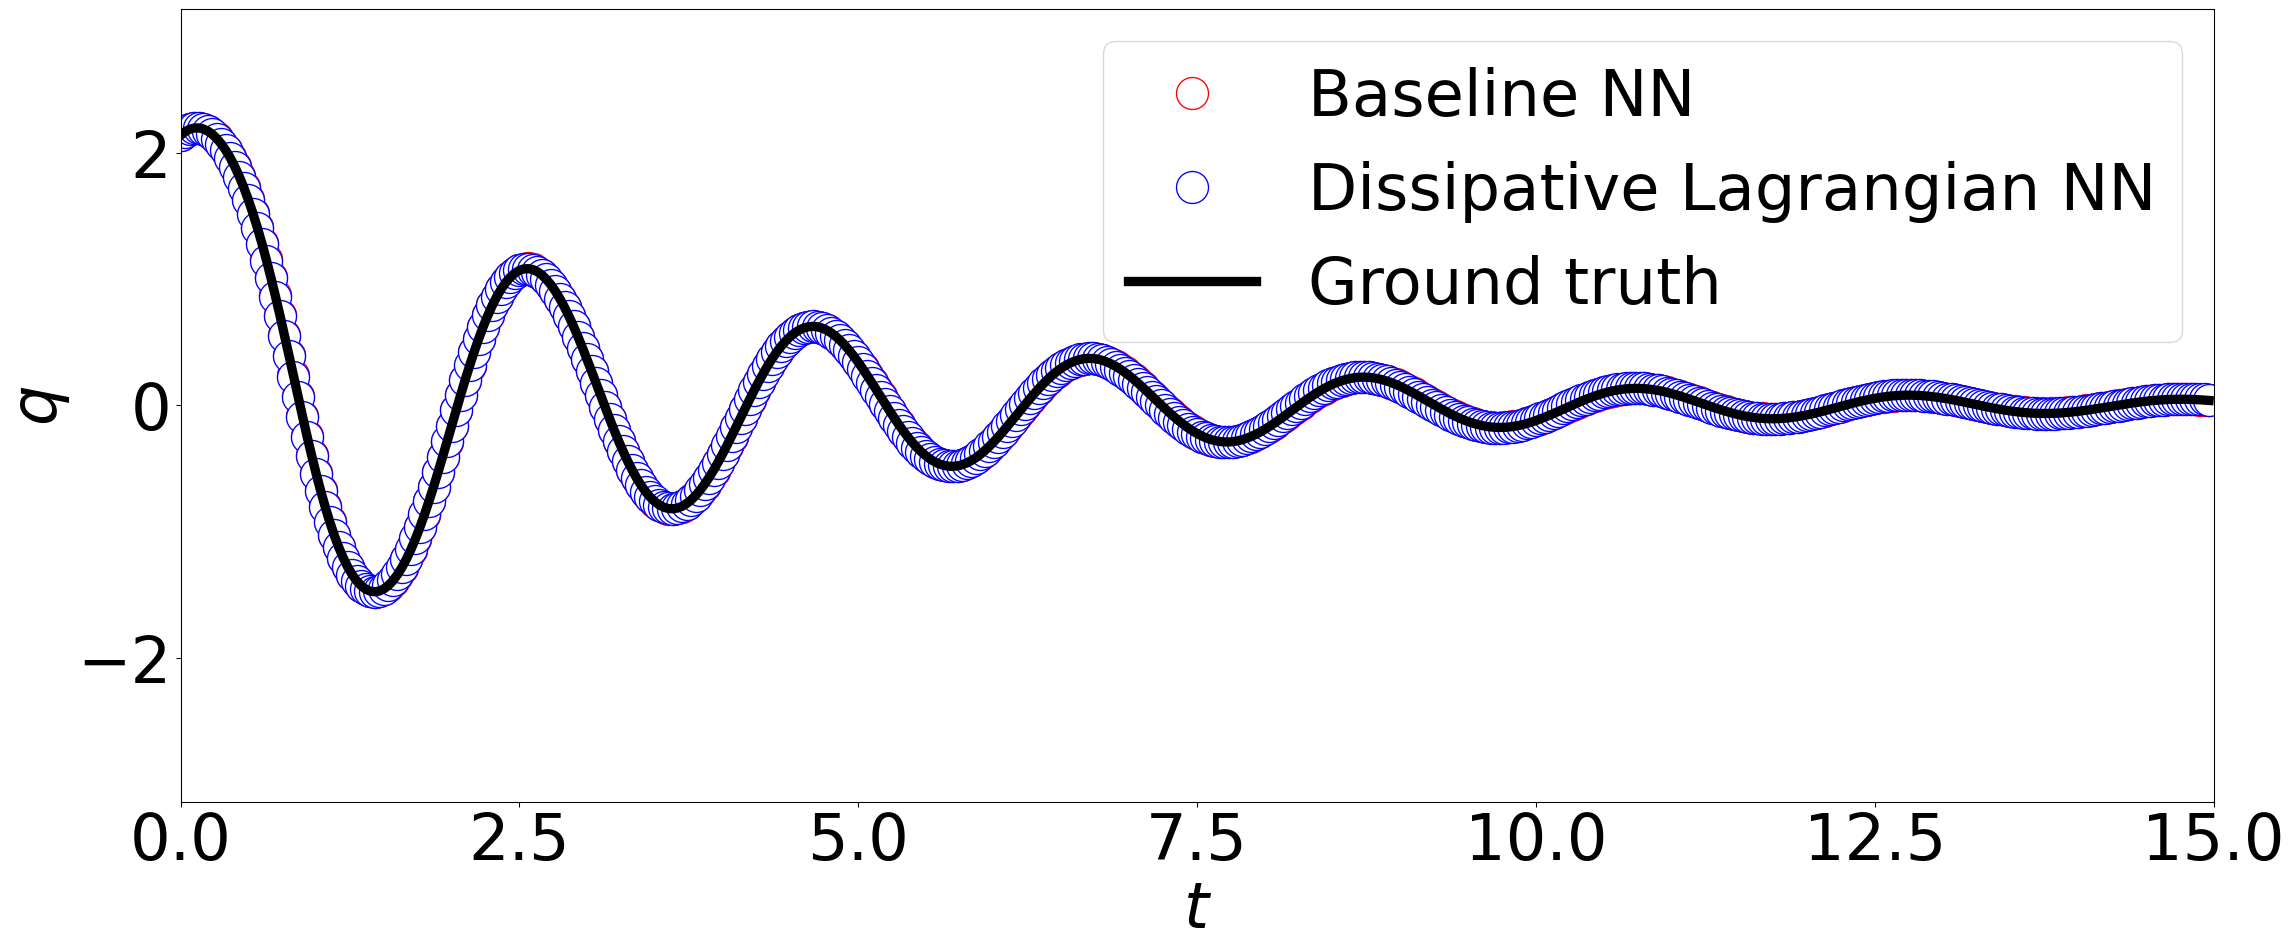

In [29]:
fig = plt.figure(figsize=[24,10], dpi=96)
plt.xlabel(r'$t$',fontsize=48)
plt.ylabel(r'${q}$',fontsize=48)
plt.tick_params(labelsize=48)
plt.xticks(np.arange(0,15*30+1,5*30/2),np.arange(0,15+1,2.5))

plt.ylim(-np.pi,np.pi)
plt.xlim(0,15*30)
plt.plot(bplot,'r.',markerfacecolor='white',markersize=48,label='Baseline NN')
plt.plot(dlplot,'b.',markerfacecolor='white',markersize=48,label='Dissipative Lagrangian NN')
plt.plot(true_ivp['y'][0],'k',lw=7,label='Ground truth')
plt.legend(loc='upper right',  fontsize=48)

plt.tight_layout()
plt.savefig('{}/pendulum_orbit.png'.format(EXPERIMENT_DIR))
plt.show()

In [30]:
BMSE = ((true_ivp['y'] - bc_ivp['y'])**2).mean()
DMSE = ((true_ivp['y'] - dlnn_ivp['y'])**2).mean()

print(BMSE)
print(DMSE)

9.56085223978534
9.561374777273835


In [31]:
from moviemaker import make_anim,save_anim

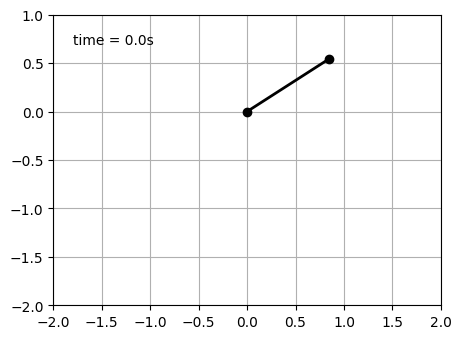

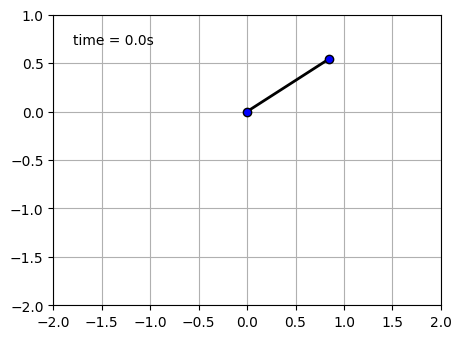

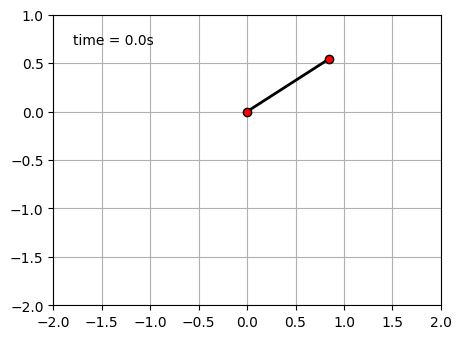

In [32]:
anim_actual = make_anim(true_ivp['y'].T,t_eval,len(t_eval),'k')
anim_dlnn = make_anim(dlnn_ivp['y'].T,t_eval,len(t_eval),'b')
anim_bc = make_anim(bc_ivp['y'].T,t_eval,len(t_eval),'r')

In [33]:
save_anim_format = "gif"

In [34]:
save_anim(anim_actual,'actual',EXPERIMENT_DIR,save_anim_format)
save_anim(anim_dlnn,'dlnn',EXPERIMENT_DIR,save_anim_format)
save_anim(anim_bc,'bc',EXPERIMENT_DIR,save_anim_format)